In [ ]:
#hi
# Install required libaries
!pip install tweepy
!pip install pandas
!pip install nltk
!pip install wordcloud
!pip install numpy
!pip install gensim
!pip install seaborn
!pip install bokeh
!pip install pyldavis==2.1.2
!pip install spacy-transformers
!python -m spacy download en_core_web_trf

In [1]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from nltk.stem.porter import *
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd
import numpy as np
import os.path
import tweepy
import re
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint
import nltk
import spacy
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/abhinav/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/abhinav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Questions we are looking to answer about the Farmers Protest in India:
1) What are the main concerns or topics that are being discussed related to farmers protest in India - Topic modelling
2) What are the general reaction or sentiment of the crowd towards each topic - Sentiment Analysis
3) Which all celebrities voiced out their opinions about the issue?
4) How does the public (within and/or outside India) feel towards celebrities?

## Set up config information

In [2]:
# CSV Names
RAW_CSV_NAME = "raw_tweets_general_large.csv"
PREPROCESSED_CSV_NAME = "preprocessed_tweets.csv"

# Twitter API Credentials
CONSUMER_KEY = "XXXXXXXXXXXXXXXXXX"
CONSUMER_SECRET = "XXXXXXXXXXXXXXXXXXXXX"
ACCESS_KEY = "XXXXXXXXXXXXXXXXXXXXXX"
ACCESS_SECRET = "XXXXXXXXXXXXXXXXXXXXXXX"

pd.set_option('display.max_colwidth', -1)

<ipython-input-2-ae1d02389e4c>:11: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


## Load Tweets

In [3]:
USE_OLD_CSV = True

if not USE_OLD_CSV or not os.path.isfile(RAW_CSV_NAME):
    # Connect to API
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_KEY, ACCESS_SECRET)
    api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

    # Query the API
    search_term = "FarmersProtest"
    max_items = 50000
    result_type = "recent"
    lang = "en"
    # Do not include retweets, ensure tweet has 1 minimum retweet and is after September 2020        
    response = tweepy.Cursor(api.search, q=search_term+"-filter:retweets min_retweets:1 since:2020-09-01",
                             result_type=result_type, lang=lang, tweet_mode="extended").items(max_items)

    # Extract only the required keys from the response
    tweets = [
        [tweet.created_at,
         tweet.full_text,
         tweet.retweet_count,
         tweet.favorite_count,
         tweet.user.screen_name,
         tweet.user.followers_count,
         tweet.user.verified,
         tweet.author.location
        ] for tweet in response]

    # Store as CSV for later
    tweets_df = pd.DataFrame(data=tweets, columns=["created_at", "text", "retweet_count", "favorite_count",
    "user_screen_name", "user_followers_count", "user_verified","country"])
    tweets_df.to_csv(RAW_CSV_NAME, quotechar='"', encoding='utf8', index = False, header=True)

raw_tweets = pd.read_csv(RAW_CSV_NAME, quotechar='"', encoding='utf8')

In [4]:
raw_tweets.describe()

,id
count,1.000010e+05
mean,1.369129e+18
std,4.630924e+15
min,1.361272e+18
25%,1.364996e+18
50%,1.368920e+18
75%,1.373364e+18
max,1.377047e+18


## Preprocessing

In [5]:
tweets_df = raw_tweets.copy()
tweets_df['text_processed'] = raw_tweets['content']

# Remove any links
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'http\S+', '', x))

# Remove any timestamps
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'[0-9]{1,2}:[0-9]{1,2}:[0-9]{1,2}', '', x))

# Remove punctuation
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('[=,:;\\.!|\-\_"}{}]', ' ', x))

# Convert remove apostrophe from words
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('[\']', '', x))

# Remove unnecessary line breaks
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r"\n", '', x))

# Remove any emojis or non-english alphabet
# (!) NOTE: this removes hindi words too
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))

# Remove any twitter handles
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('@[\w]*', '', x))

# Remove any hashtags
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('#[\w]*', '', x))

# Remove leading spaces
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'^\s+', '', x))

# Remove trailing spaces
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'[ \t]+$', '', x))

# Remove multi spaces
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(' +', ' ', x))

# Remove small words (words like "a", "ok", "are", "in" are useless)
# min_word_length = 3
# tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: ' '.join([word for word in x.split() if len(word)>min_word_length]))

# Remove duplicate tweets (keep latest)
tweets_df = tweets_df.drop_duplicates(subset='text_processed', keep="last")

# Remove any empty columns after all the processing
tweets_df['text_processed'].replace('', np.nan, inplace=True)
tweets_df.dropna(subset=['text_processed'], inplace=True)
 
# Store as CSV for later, tweets_df will contain the headers
processed_tweets_df = pd.DataFrame(data=tweets_df)
print(processed_tweets_df['text_processed'].head())
# processed_tweets_df.to_csv(PREPROCESSED_CSV_NAME, quotechar='"', encoding='utf8', index = False, header=True)

1     With harvesting season approaching the smoke from the faraway fields of Punjab Farmers will trouble Delhi more than the 300 deaths of the Farmers at its doorstep in the                                                        
7     This guy was open giving death threats to people wooah You guys are dead Who are you guys Farmer supporters?People who vote against Modi/RSS? Protestors against farm laws?Sikhs? Punjabis? Democracy loving citizens of Canada?
9     Yes good point                                                                                                                                                                                                                  
13    Nazis kept shouting Hitler Hitler until destruction of the Germany Modi Bhagats are behaving like the same way Godi media is playing the role of Goebels                                                                        
14    Having fought for so long to survive old dirty grandpa Modi just dont 

 ## Word Cloud

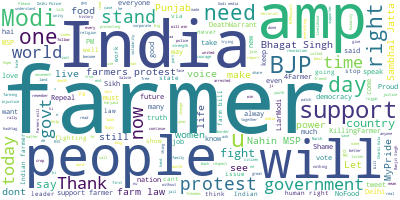

In [6]:
# join the words of the different tweets together into one string
long_string = ' '.join([text for text in processed_tweets_df['text_processed']])
new_long_string = ' '.join(set(long_string.split(" ")))

# create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# generate a word cloud
wordcloud.generate(long_string)

# visualize the word cloud
wordcloud.to_image()

### Sentiment Analysis of twitter users(unique) towards farmers bill

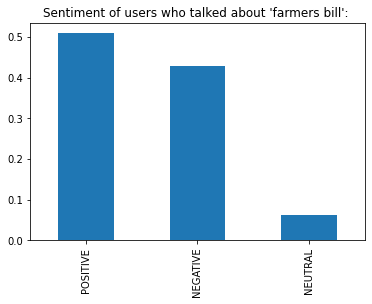

In [7]:
processed_tweets_df.reset_index(drop=True)
processed_total_df = processed_tweets_df.groupby('username')['text_processed'].unique().apply(lambda x: ','.join(x)).reset_index()
sid = SentimentIntensityAnalyzer()
df = pd.DataFrame()
df["text_processed"]=processed_total_df[processed_total_df["text_processed"].str.find(r'bill')!=-1]["text_processed"].to_numpy()
df['scores'] = df['text_processed'].apply(lambda text_processed: sid.polarity_scores(text_processed))

df['compound'] = df['scores'].apply(lambda score_dict: score_dict['compound'])
df['sentiment_type']=''
df.loc[df.compound>0,'sentiment_type']='POSITIVE'
df.loc[df.compound==0 ,'sentiment_type']='NEUTRAL'
df.loc[df.compound<0,'sentiment_type']='NEGATIVE'
df.sentiment_type.value_counts(normalize=True).plot.bar(title="Sentiment of users who talked about 'farmers bill': ")
plt.show()

# Topic Modelling
### To identify the main concerns or topics that are being discussed regarding farmers protest

In [8]:
stop_words = stopwords.words('english')

def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
  return [[word for word in simple_preprocess(str(doc)) 
    if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

data = tweets_df.text_processed.values.tolist()

data_words = list(sent_to_words(data))

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# remove stop words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# create a dictionary
id2word = corpora.Dictionary(data_lemmatized)

# create a corpus
texts = data_lemmatized

# convert the corpus into a BoW representation
corpus = [id2word.doc2bow(text) for text in texts]

#Identify TF-IDF and use this as corpus
tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [9]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [10]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=50, step=1)

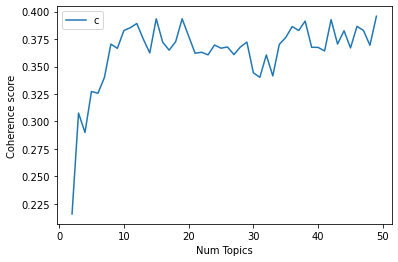

Num Topics = 2  has Coherence Value of 0.2157
Num Topics = 3  has Coherence Value of 0.3076
Num Topics = 4  has Coherence Value of 0.2899
Num Topics = 5  has Coherence Value of 0.3272
Num Topics = 6  has Coherence Value of 0.3256
Num Topics = 7  has Coherence Value of 0.34
Num Topics = 8  has Coherence Value of 0.3704
Num Topics = 9  has Coherence Value of 0.3665
Num Topics = 10  has Coherence Value of 0.3828
Num Topics = 11  has Coherence Value of 0.3854
Num Topics = 12  has Coherence Value of 0.3892
Num Topics = 13  has Coherence Value of 0.375
Num Topics = 14  has Coherence Value of 0.3624
Num Topics = 15  has Coherence Value of 0.3935
Num Topics = 16  has Coherence Value of 0.3721
Num Topics = 17  has Coherence Value of 0.3649
Num Topics = 18  has Coherence Value of 0.3726
Num Topics = 19  has Coherence Value of 0.3935
Num Topics = 20  has Coherence Value of 0.3778
Num Topics = 21  has Coherence Value of 0.3621
Num Topics = 22  has Coherence Value of 0.363
Num Topics = 23  has Cohe

In [11]:
# Show graph
start=2; limit=50; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

With the coherence score seems to keep increasing with the number of topics, it may make better sense to pick the model that gave the highest CV before flattening out or a major drop. In this case, we picked **k=12**

In [12]:
num_topics=12

In [13]:
# Select the model and print the topics
optimal_model = model_list[10]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.025*"stay" + 0.024*"kaur" + 0.022*"link" + 0.019*"heart" + 0.019*"market" '
  '+ 0.018*"produce" + 0.018*"shame" + 0.014*"stay_unite" + 0.014*"bhi" + '
  '0.014*"beautiful"'),
 (1,
  '0.050*"arrest" + 0.049*"police" + 0.025*"toolkit" + 0.025*"delhi" + '
  '0.016*"people" + 0.014*"call" + 0.014*"terrorist" + 0.011*"detain" + '
  '0.011*"free" + 0.010*"climate_activist"'),
 (2,
  '0.058*"hai" + 0.042*"solidarity" + 0.035*"follow" + 0.031*"kisan" + '
  '0.031*"release" + 0.017*"aa" + 0.015*"delhi" + 0.014*"ke" + 0.014*"ho" + '
  '0.013*"border"'),
 (3,
  '0.108*"farmer" + 0.032*"food" + 0.020*"amp" + 0.018*"nation" + 0.017*"save" '
  '+ 0.016*"india" + 0.014*"price" + 0.013*"indian" + 0.013*"support" + '
  '0.013*"future"'),
 (4,
  '0.035*"rojgar" + 0.029*"truth" + 0.026*"job" + 0.020*"true" + '
  '0.016*"silence" + 0.015*"love" + 0.013*"tell" + 0.012*"sambhal_jatta" + '
  '0.012*"video" + 0.011*"write"'),
 (5,
  '0.037*"fight" + 0.024*"right" + 0.019*"win" + 0.018*"farmer" + 0.

### What is the Dominant topic and its percentage contribution in each tweet

In [14]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.5476,"law, farmer, protest, farm, msp, repeal, delhi, back, bill, court",With harvesting season approaching the smoke from the faraway fields of Punjab Farmers will trouble Delhi more than the 300 deaths of the Farmers at its doorstep in the
1,1,1.0,0.2637,"arrest, police, toolkit, delhi, people, call, terrorist, detain, free, climate_activist",This guy was open giving death threats to people wooah You guys are dead Who are you guys Farmer supporters?People who vote against Modi/RSS? Protestors against farm laws?Sikhs? Punjabis? Democracy loving citizens of Canada?
2,2,9.0,0.6944,"say, read, protest, good, punjab, word, youth, farmer, well, watch",Yes good point
3,3,0.0,0.5815,"stay, kaur, link, heart, market, produce, shame, stay_unite, bhi, beautiful",Nazis kept shouting Hitler Hitler until destruction of the Germany Modi Bhagats are behaving like the same way Godi media is playing the role of Goebels
4,4,7.0,0.3255,"law, farmer, protest, farm, msp, repeal, delhi, back, bill, court",Having fought for so long to survive old dirty grandpa Modi just dont see this government giving a damn about it They force some people to actually take their lives there in the protest sites or when they go back home
5,5,5.0,0.7708,"fight, right, win, farmer, take, stop, stand, go, get, injustice",No Religion can be greater than Humanity
6,6,8.0,0.7660,"india, amp, modi, indian, government, democracy, govt, activist, sikh, farmer",amarinder when would you listen to them &amp treating them well &amp loved like your grand daughter They too are someones family &amp loved children to whom you beat up grab from hair for asking jobs &amp pays that youre holding on of teachers since 2016
7,7,11.0,0.7237,"today, thank, singh, share, day, news, great, hashtag, much, send",If we induldge with a mentally sick person we must have to lose our mental level too wich is neither fair nor we like to be So dont waste time and energy keep distance and ignore mentally sick Modi Bhagats
8,8,9.0,0.8837,"say, read, protest, good, punjab, word, youth, farmer, well, watch",Farmers are burdened with debts and bankruptcy If Modi shut down all the schools/colleges how do you expect them to repay without working? Some of the families have taken loans for medical treatments weddings etc Do you see the significant factor here?
9,9,3.0,0.8109,"farmer, food, amp, nation, save, india, price, indian, support, future",No academic should put up with this Kudos to Dr Truschke for bravely speaking up and standing steadfast in her beliefs and convictions based on extensive study of subject matter in a structured form


### The most representative sentence for each topic

In [15]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.8979,"stay, kaur, link, heart, market, produce, shame, stay_unite, bhi, beautiful",BharatBandh BharatBandh BharatBandh BharatBandh BharatBandh BharatBandh BharatBandh BharatBandh
1,1.0,0.8790,"arrest, police, toolkit, delhi, people, call, terrorist, detain, free, climate_activist",they are treating every person with 3rd degree torture what these protestors have done
2,2.0,0.9693,"hai, solidarity, follow, kisan, release, aa, delhi, ke, ho, border",100% Right msg aa ji Eh bache v kisana di Amiat nu smj de ne k o sari jindgi kisani vich kaat dende ne pure desh videsh da Anaaz pura krn li kini mehnat krde rehnde ne jo Roti di kdr krde ne o kisan da saath de rahe ne ena chote bache aa nu dekh k hi smjo
3,3.0,0.9295,"farmer, food, amp, nation, save, india, price, indian, support, future",FARMERS are the backbone of the country whom Govt is destroying for the benefit of their Corporate Friends But we will Fight together for the rights of the Farmers
4,4.0,0.9083,"rojgar, truth, job, true, silence, love, tell, sambhal_jatta, video, write",Farmers are not happy are not happy rojgar do Middle class is not happy ambani and Adani are happy so Modi happy jawab do
5,5.0,0.9389,"fight, right, win, farmer, take, stop, stand, go, get, injustice",Feminism isnt about making women stronger women are already stronger Its about changing the way the world perceives that strength And we can see the power and strength of women in
6,6.0,0.9295,"farmer, support, protest, stand, keep, right, world, feed, movement, call",11 farmer no food no life Farmers are justified in seeking the rollback of farmers bills that undermine their rights Stand up against police brutality and corruption
7,7.0,0.9295,"law, farmer, protest, farm, msp, repeal, delhi, back, bill, court",Khalistan is not our demand Our demand is MSP Our demand is repeal the Farm Laws Repeal the laws and we go home
8,8.0,0.9295,"india, amp, modi, indian, government, democracy, govt, activist, sikh, farmer",meena1 Marmat MMES Malarna Meena Farmers will create new history by overturning modi shah bjp rss
9,9.0,0.9320,"say, read, protest, good, punjab, word, youth, farmer, well, watch",is being celebrated in a unique way at protest site How will the farmers strike a balance between farming and protest? To know more watch this report by More Videos


### Frequency Distribution of Word Counts in Documents

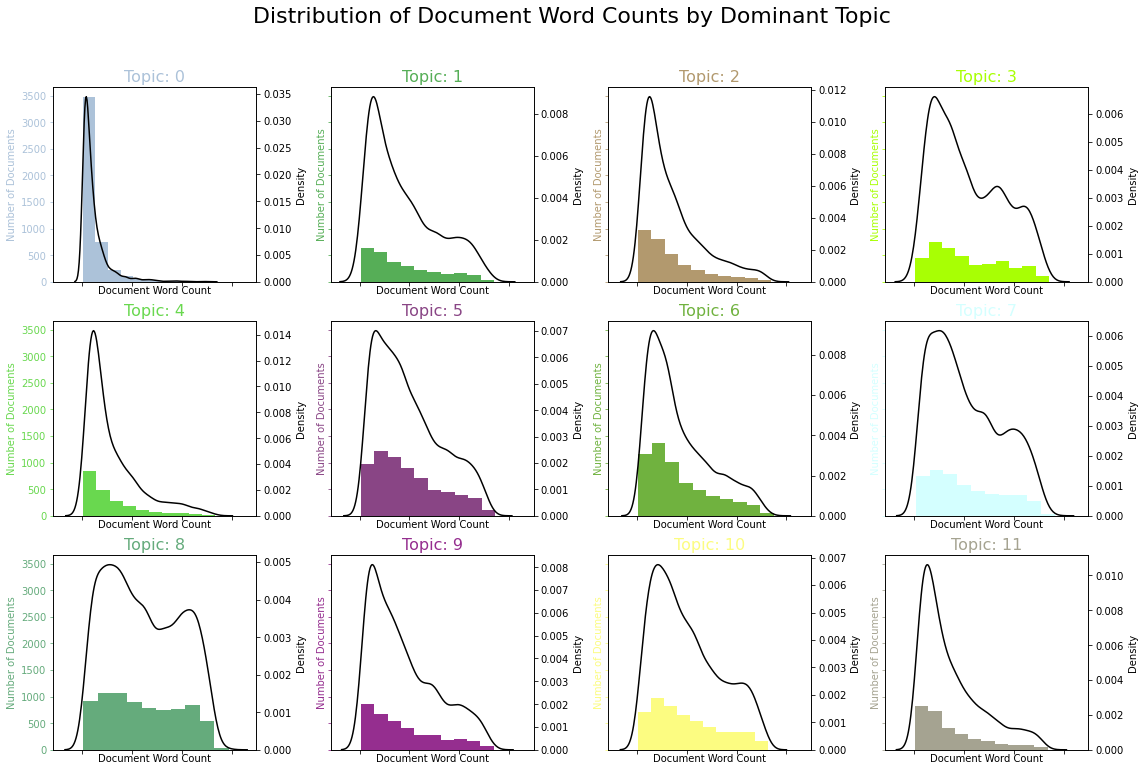

In [16]:
doc_lens = [len(d) for d in df_dominant_topic.Text]
cols = np.array([color for name, color in mcolors.XKCD_COLORS.items()])

fig, axes = plt.subplots((num_topics//4)+1,4,figsize=(16,14), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):  
    if i<num_topics:
        df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
        doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
        ax.hist(doc_lens, color=cols[i])
        ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
        sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
        ax.set(xlabel='Document Word Count')
        ax.set_ylabel('Number of Documents', color=cols[i])
        ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))
    else:
        ax.set_visible(False)

fig.tight_layout()
fig.subplots_adjust(top=0.90)
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

### Word Clouds of Top N Keywords in Each Topic

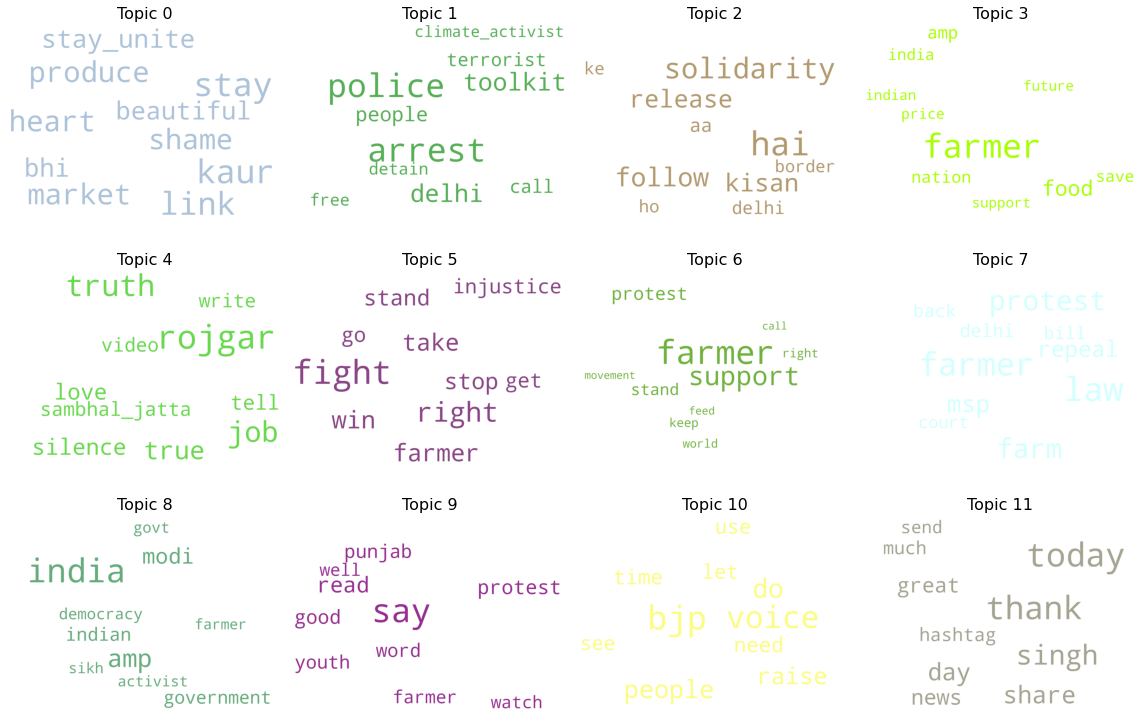

In [17]:
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False, num_topics=num_topics, num_words=10)

fig, axes = plt.subplots((num_topics//4)+1, 4, figsize=(16,14), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    if i<num_topics:
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')
    else:
        ax.set_visible(False)


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### Word Counts of Topic Keywords

<ipython-input-18-c594632555c6>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-18-c594632555c6>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-18-c594632555c6>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-18-c594632555c6>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-18-c594632555c6>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation

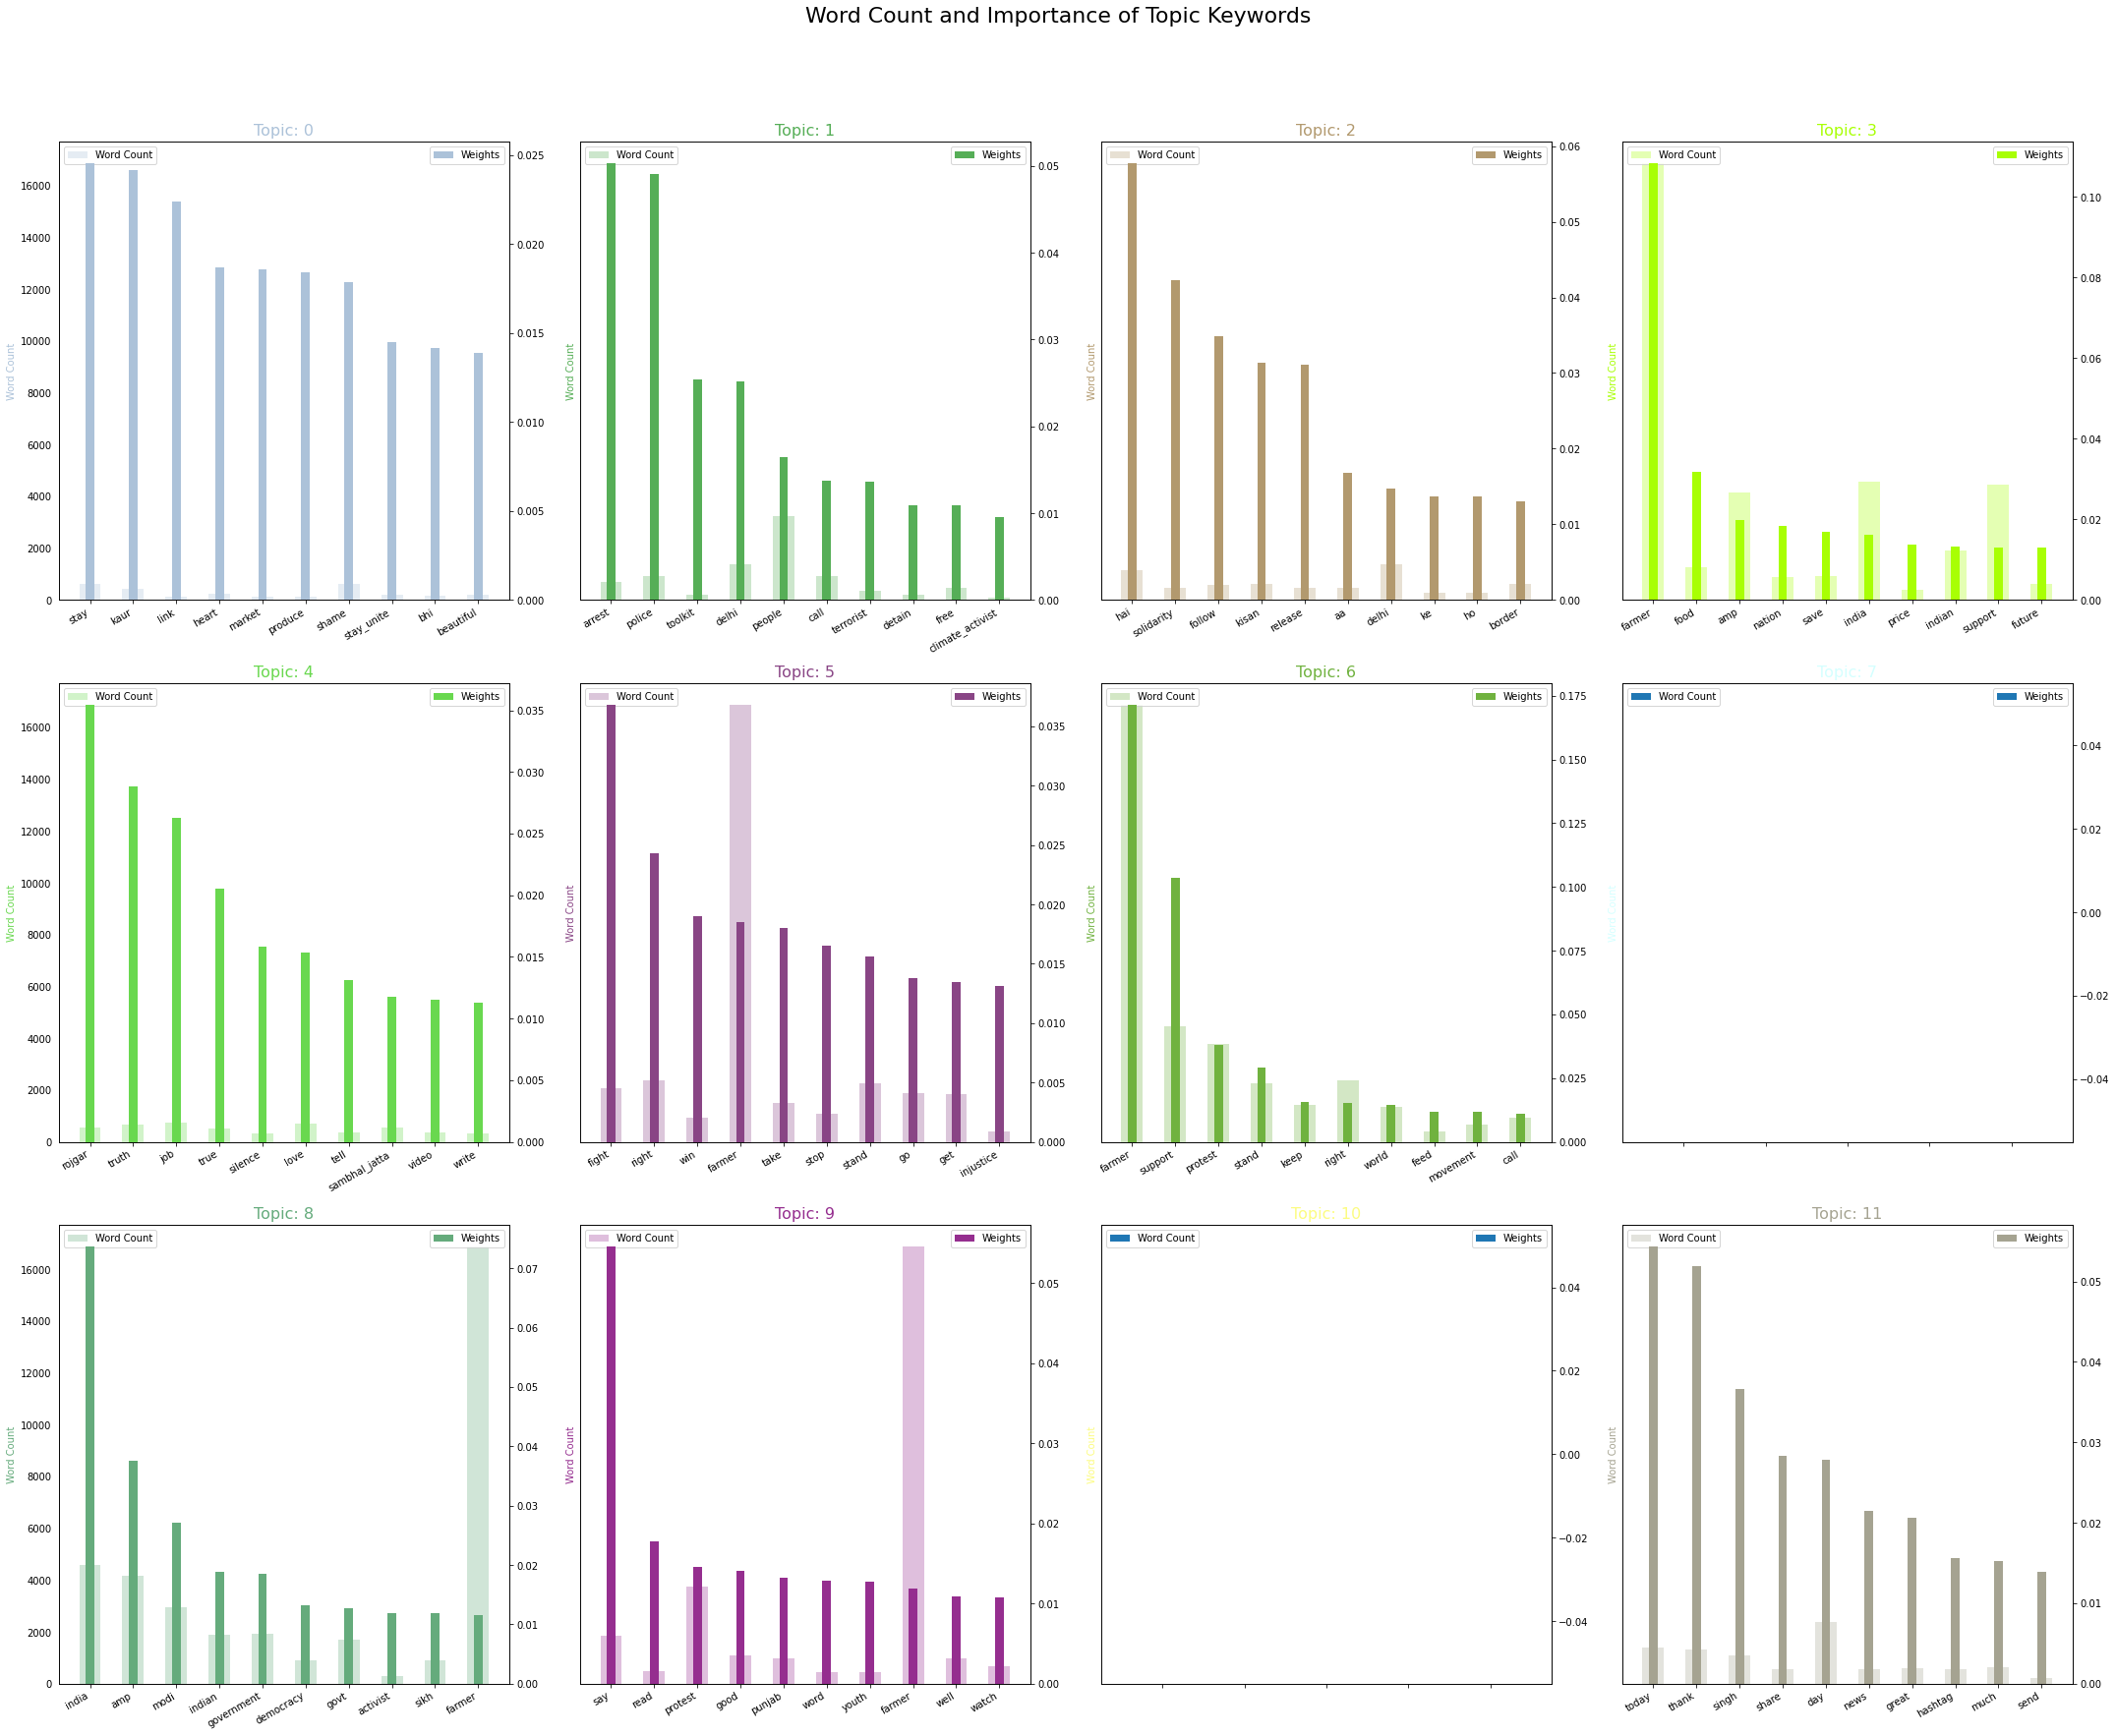

In [18]:
from collections import Counter
topics = optimal_model.show_topics(formatted=False)
data_flat = [w for w_list in texts for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots((num_topics//4)+1, 4, figsize=(30,30), sharey=True)
for i, ax in enumerate(axes.flatten()):
    if i<num_topics:
        ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
#         ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
        ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')
    else:
        ax.set_visible(False)
        

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

### Compute Model Perplexity and Coherence Score

In [19]:
# Compute Perplexity
print('\nPerplexity: ', optimal_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=optimal_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -10.197922343303922

Coherence Score:  0.3891878160476232


### t-distributed stochastic neighbor embedding Clustering Chart

In [20]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(optimal_model[corpus]):
    row = row_list[0] if optimal_model.per_word_topics else row_list 
    topic_weights.append([w for i, w in row])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(num_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=cols[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 38924 samples in 0.047s...
[t-SNE] Computed neighbors for 38924 samples in 9.464s...
[t-SNE] Computed conditional probabilities for sample 1000 / 38924
[t-SNE] Computed conditional probabilities for sample 2000 / 38924
[t-SNE] Computed conditional probabilities for sample 3000 / 38924
[t-SNE] Computed conditional probabilities for sample 4000 / 38924
[t-SNE] Computed conditional probabilities for sample 5000 / 38924
[t-SNE] Computed conditional probabilities for sample 6000 / 38924
[t-SNE] Computed conditional probabilities for sample 7000 / 38924
[t-SNE] Computed conditional probabilities for sample 8000 / 38924
[t-SNE] Computed conditional probabilities for sample 9000 / 38924
[t-SNE] Computed conditional probabilities for sample 10000 / 38924
[t-SNE] Computed conditional probabilities for sample 11000 / 38924
[t-SNE] Computed conditional probabilities for sample 12000 / 38924
[t-SNE] Computed conditional probabilities for sam

Loading BokehJS ...

In [21]:
import os
import pyLDAvis.gensim
import pickle 
import pyLDAvis

pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./topic-modelled')

LDAvis_prepared = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
with open(LDAvis_data_filepath, 'wb') as f:
  pickle.dump(LDAvis_prepared, f)

with open(LDAvis_data_filepath, 'rb') as f:
  LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './topic-modelled.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.117158 -0.049892  1       1        14.282496
5      0.112432 -0.064121  2       1        11.195706
10     0.056296 -0.166290  3       1        10.244546
6      0.169434  0.120388  4       1        9.801282 
7      0.129129  0.190615  5       1        9.762201 
3      0.160001  0.138707  6       1        8.463673 
9      0.049036 -0.062100  7       1        7.905748 
1     -0.064153 -0.115857  8       1        6.697741 
11    -0.091017 -0.144254  9       1        6.365522 
2     -0.313548  0.210526  10      1        6.119871 
4     -0.097396 -0.072478  11      1        5.275288 
0     -0.227372  0.014756  12      1        3.885925 , topic_info=         Term          Freq         Total Category  logprob  loglift
5     farmer   16940.000000  16940.000000  Default  30.0000  30.0000
145   support  5166.000000   5166.000000   Default  29.0000  29.0000
243   india    6016.000000   6016.000000   Default  28.0000  28.0000
20    law      2821.000000   2821.000000   Default  27.0000  27.0000
277   say      2321.000000   2321.000000   Default  26.0000  26.0000
...   ...              ...           ...       ...      ...      ...
305   soul     197.850936    237.967548    Topic12 -4.4863   3.0632 
306   stay     431.291956    768.214853    Topic12 -3.7071   2.6705 
1318  late     202.281613    283.743079    Topic12 -4.4642   2.9094 
42    play     194.443613    268.962082    Topic12 -4.5037   2.9234 
1335  shame    314.102923    775.540307    Topic12 -4.0241   2.3440 

[718 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
802   10     0.995847  aa           
802   12     0.002142  aa           
1913  11     0.993821  aap          
499   11     0.993263  absolutely   
1090  4      0.322309  abuse        
...   ..          ...         ...   
489   10     0.993248  yogendrayadav
1662  7      0.997463  young        
1730  7      0.805101  youth        
1730  8      0.192870  youth        
4194  6      0.987475  zindabad     

[1787 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 6, 11, 7, 8, 4, 10, 2, 12, 3, 5, 1])

### Topics:
1) Repeal the farmers bill - Stand with farmers
2) World sikh day, Minimum support price - Farmers being detained 
3) Write and share about human right violations
4) Toolkit for farmers bill - release the charges on the developers
5) Farmers protest reached Delhi border
6) Raise voice for Indian farmers
7) Keep supporting and sharing farmers protest - Court grant bail to arrested farmers
8) Peaceful fiht against Modi government
9) Journalists and news channels supporting farmers protests
10) Farmers overcoming water shortage - which happened due to road bloack by gov as election closes by
11) Indian BJP government police arrest.
12) Share and support farmers - Court gives bail to farmer protesters

## Sentiment of the crowd towards towards these topics

/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1434: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.tick_pos = ax.

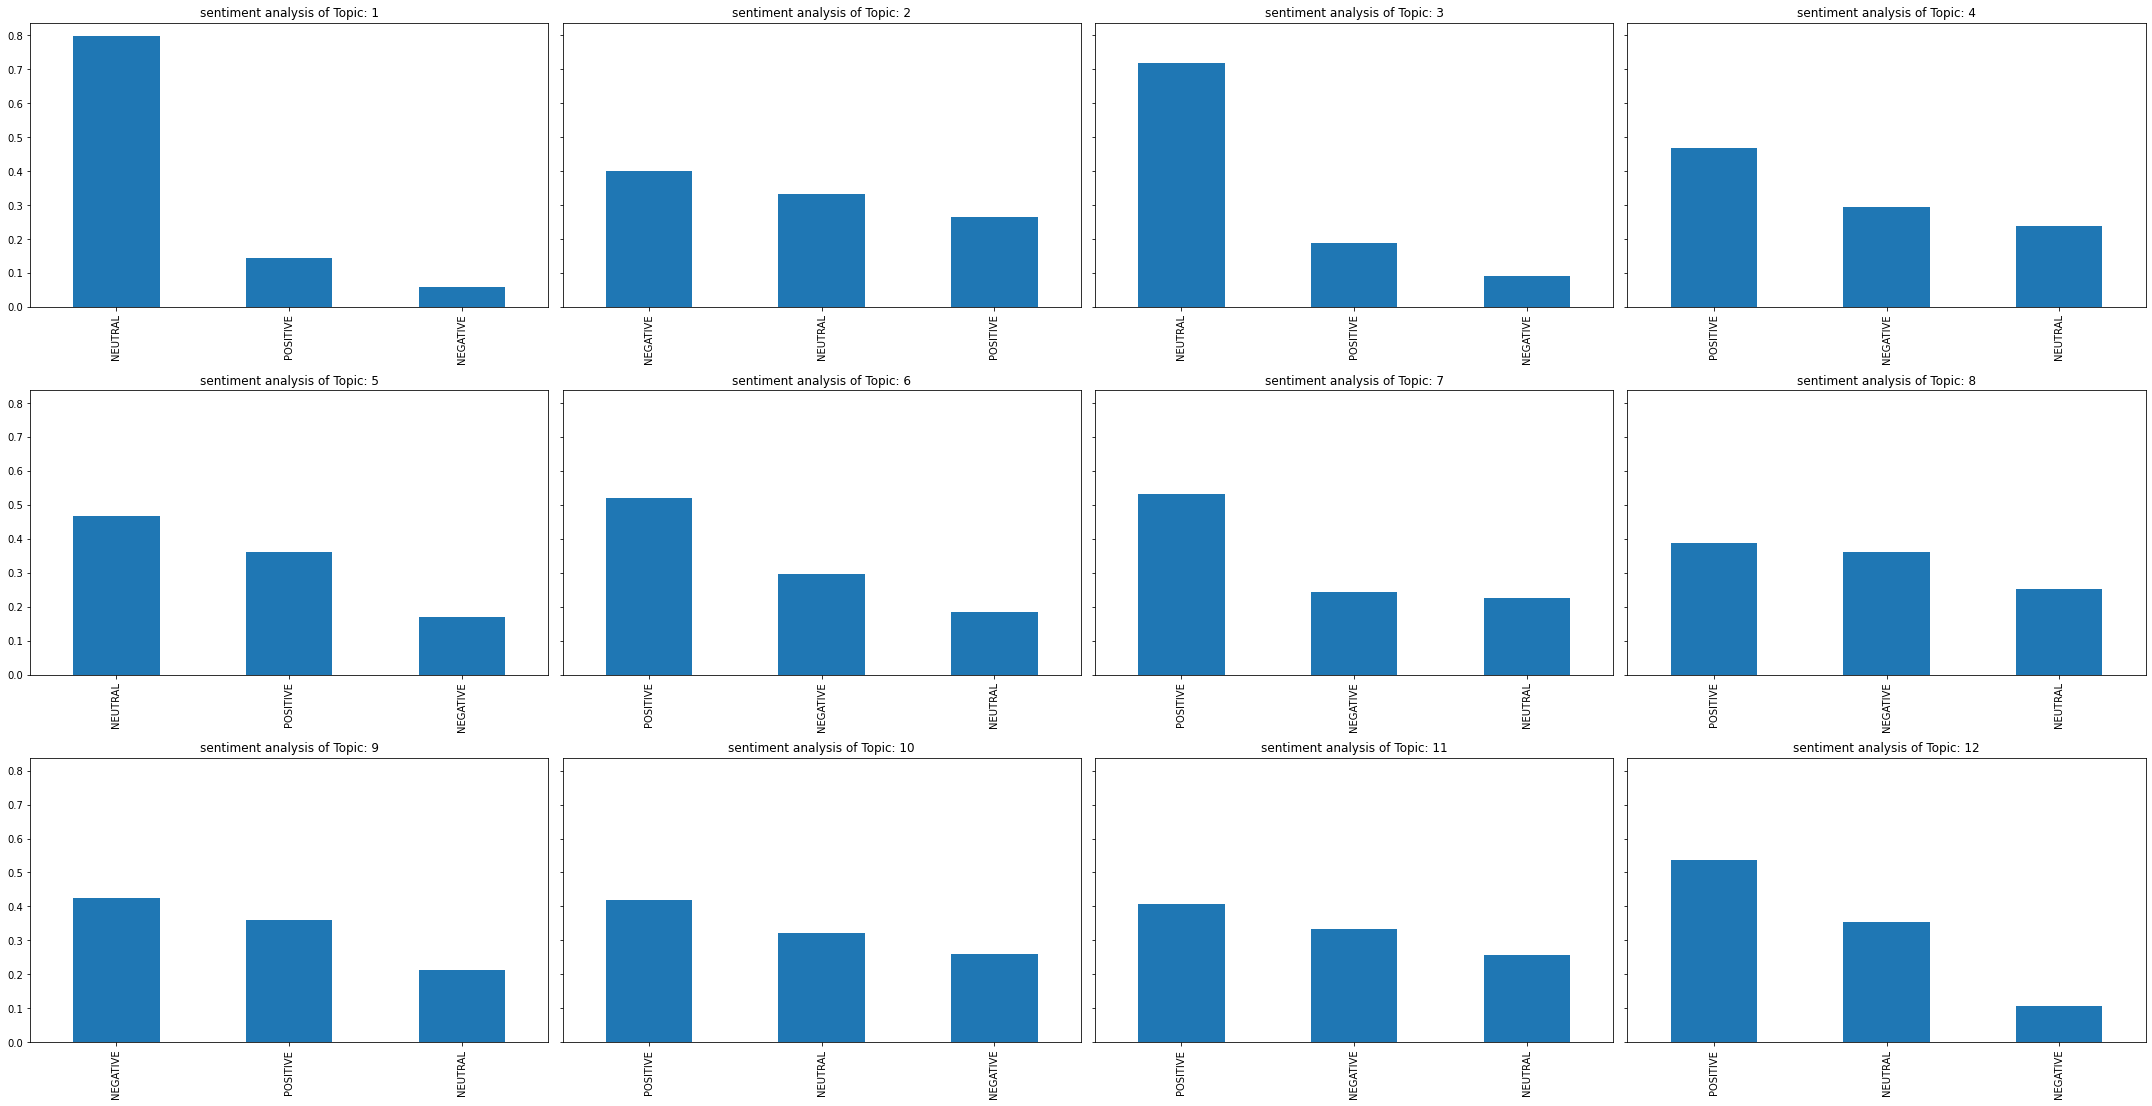

In [22]:
Topics =  list(sent_topics_outdf_grpd)
fig, axes = plt.subplots(6, 4, figsize=(30,30), sharey=True)

fig.set_tight_layout(True)
for i, ax in enumerate(axes.flatten()):
    if i<num_topics:
        topic = Topics[i][1]
        sid = SentimentIntensityAnalyzer()
        df = pd.DataFrame()
        df["text_processed"]=topic[0].to_numpy()
        df['scores'] = df['text_processed'].apply(lambda text_processed: sid.polarity_scores(text_processed))

        df['compound'] = df['scores'].apply(lambda score_dict: score_dict['compound'])
        df['sentiment_type']=''
        df.loc[df.compound>0,'sentiment_type']='POSITIVE'
        df.loc[df.compound==0 ,'sentiment_type']='NEUTRAL'
        df.loc[df.compound<0,'sentiment_type']='NEGATIVE'
        df.sentiment_type.value_counts(normalize=True).plot.bar(ax=ax,title="sentiment analysis of Topic: "+str(i+1))
    else:
        ax.set_visible(False)

## Top Celebrities tweeted regarding #FarmersProtest

In [23]:
raw_tweets_celeb = pd.read_csv('raw_tweets_celeb.csv')
raw_tweets_celeb.head(10)

/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,date,content,username,retweet_counter,favorite_count,reply_count,user_followers_count,country
0,1365610475753328640,2021-02-27 10:31:23+00:00,मेरठ की किसान महापंचायत कवर करने पहुँचे ABP न्यूज़ के सीनियर रिपोर्ट रक्षित सिंह ने महापंचायत के मंच पर चढ़ नोकरी छोड़ी। उन्हों ने आरोप लगाया की न्यूज चैनल खबर सच्ची खबर नहीं दिखाती.\n#FarmersProtest 1/3 https://t.co/03ZInJ4XTZ,zoo_bear,5919,18613,410,237275,India
1,1360882069161803779,2021-02-14 09:22:23+00:00,"disha ravi, a 21-year-old climate activist, has been arrested by delhi police for sharing a toolkit @GretaThunberg posted in support of the #farmersprotest. \n\ndisha’s arrest is alarming and the world needs to pay attention. #freedisharavi\n\nhttps://t.co/IYGsLpNjwZ",rupikaur_,4623,8905,643,272886,NaN
2,1360169510079111173,2021-02-12 10:10:56+00:00,मध्यप्रदेश में निजी व्यापारी 200 करोड़ का धान खरीदकर भाग गया। किसान पैसे के लिए धरना दे रहे है।\nअब भी बताना पड़ेगा काला क्या है\n#FarmLaws #FarmersProtest #किसान_एकता_जिंदाबाद,RakeshTikaitBKU,7664,25685,570,257906,"Sisauli, India"
3,1359013362881994752,2021-02-09 05:36:49+00:00,To all of my influencer/celeb friends- read up on this #FarmersProtest 👀,AmandaCerny,15661,81331,2027,1131254,"Florida, USA"
4,1358826225762897920,2021-02-08 17:13:12+00:00,I am calling on leaders across the world to demand the immediate release of Nodeep Kaur – a worker and Dalit rights activist jailed and brutalized for organizing in solidarity with the #Farmersprotest. #FreeNodeepKaur https://t.co/iKWQUOjWd0,GurratanSingh,6693,19018,337,27812,"Brampton, Ontario"
5,1358164266474348544,2021-02-06 21:22:49+00:00,"Ate a wheat tandoori roti. Grateful. Amazed at the smell &amp; taste of pure wheat. If 1 farmer dies, we all die. If 1 farmer protests, we all protest... Annadhaatha sukhi bhava...god bless and save my saviour. The farmer decides the quantity and price of his harvest. #FarmersProtest",Actor_Siddharth,8105,41723,1916,4337301,India under siege
6,1357965078373388289,2021-02-06 08:11:19+00:00,Happy to see so many supporting the #FarmersProtest in New Delhi. These farmers deserve the right to farm their land and survive. Let's stand with them!\n\n #standwithfarmers,PhogatRitu,6885,31661,898,162468,"Balali,Haryana"
7,1357903782324047872,2021-02-06 04:07:44+00:00,दिल्ली के अंदर छोटे छोटे ग्रुप में बंटे हुए आंदोलनकारी अचानक फ्लैश प्रोटेस्ट करके ट्रैफिक रोक सकते हैं : - खुफिया रिपोर्ट। \n#FarmersProtest,DChaurasia2312,3041,17858,476,901822,"New Delhi, Delhi"
8,1357848864556998660,2021-02-06 00:29:31+00:00,"The Indian government is going after @rihanna, @GretaThunberg and @meenaharris for supporting the #FarmersProtest because they’re scared the world will find out what's happening. Keep telling the truth. Keep standing in solidarity.\n https://t.co/rHtVU4eJA7",PiperPerabo,6823,18876,1373,185715,NaN
9,1357768519430070276,2021-02-05 19:10:15+00:00,Standing in solidarity with the #FarmersProtest in India. Read about who they are and why they’re protesting below. https://t.co/yWtEkqQynF,SusanSarandon,15156,47341,3362,711751,"New York, NY"


In [24]:
tweets_df = raw_tweets_celeb.copy()
tweets_df['text_processed'] = raw_tweets_celeb['content']

# Remove any links
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'http\S+', '', x))

# Remove any timestamps
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'[0-9]{1,2}:[0-9]{1,2}:[0-9]{1,2}', '', x))

# Remove punctuation
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('[=,:;\\.!|\-\_"}{}]', ' ', x))

# Convert remove apostrophe from words
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('[\']', '', x))

# Remove unnecessary line breaks
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r"\n", '', x))

# Remove any emojis or non-english alphabet
# (!) NOTE: this removes hindi words too
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))

# Remove any twitter handles
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('@[\w]*', '', x))

# Remove leading spaces
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'^\s+', '', x))

# Remove trailing spaces
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'[ \t]+$', '', x))

# Remove multi spaces
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(' +', ' ', x))

# Remove small words (words like "a", "ok", "are", "in" are useless)
# min_word_length = 3
# tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: ' '.join([word for word in x.split() if len(word)>min_word_length]))

# Remove duplicate tweets (keep latest)
tweets_df = tweets_df.drop_duplicates(subset='text_processed', keep="last")

# Remove any empty columns after all the processing
tweets_df['text_processed'].replace('', np.nan, inplace=True)
tweets_df.dropna(subset=['text_processed'], inplace=True)
 
# Store as CSV for later, tweets_df will contain the headers
processed_tweets_df = pd.DataFrame(data=tweets_df)
processed_tweets_df.to_csv("preprocessed_tweets_celeb.csv", quotechar='"', encoding='utf8', index = False, header=True)
processed_tweets_df.reset_index(drop=True,inplace=True)

/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:11: DeprecationWarning: invalid escape sequence \-
<>:24: DeprecationWarning: invalid escape sequence \w
<>:11: DeprecationWarning: invalid escape sequence \-
<>:24: DeprecationWarning: invalid escape sequence \w
<ipython-input-24-816e40502908>:11: DeprecationWarning: invalid escape sequence \-
  tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('[=,:;\\.!|\-\_"}{}]', ' ', x))
<ipython-input-24-816e40502908>:24: DeprecationWarning: invalid escape sequence \w
  tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('@[\w]*', '', x))


In [25]:
top_celeb_tweets = processed_tweets_df.iloc[processed_tweets_df.groupby('username', group_keys=False)["retweet_counter"].nlargest(1).index][["id","username","text_processed"]].reset_index(drop=True)
top_celeb_tweets.head(10)

/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,username,text_processed
0,1354088807424028673,ANI,#WATCH Delhi Protestors attacked Police at Red Fort earlier today #FarmersProtest
1,1358164266474348544,Actor_Siddharth,Ate a wheat tandoori roti Grateful Amazed at the smell &amp taste of pure wheat If 1 farmer dies we all die If 1 farmer protests we all protest Annadhaatha sukhi bhava god bless and save my saviour The farmer decides the quantity and price of his harvest #FarmersProtest
2,1357138419848159235,AlexandriaV2005,So Twitter being the mess it is right now with #GretaThunbergExposed and #IndiaAgainstPropaganda and the India activists going dark i guess the 15 year old in the U S has to explain the #FarmersProtest to yall so let me do that basically first 3 farm bills were passed 1/6
3,1359013362881994752,AmandaCerny,To all of my influencer/celeb friends read up on this #FarmersProtest
4,1349656137017171968,AshokShrivasta6,l #FarmersProtest
5,1357075217865035776,BaronDavis,Are we going to address whats happening in India ? Let my good people free Unfair to those who struggle the farmers provide a way of living and they need to have a right to a way of life Join me and lets bring awareness #FarmersProtest We all in this together
6,1357755699162398720,BobBlackman,There has been much social media coverage around the #FarmersProtest in #India Very useful guide to the legislation and the impact on farmers 1/2
7,1356704210004377602,ClaudiaWebbe,Solidarity to the Indian Farmers Thank you Rihanna In an era where political leadership is lacking we are grateful for others stepping forward#FarmersProtest
8,1357579938224775169,DChaurasia2312,26 6 #FarmersProtest
9,1356694884615340037,GretaThunberg,We stand in solidarity with the #FarmersProtest in India


### Analyse the sentiment towards these tweets from replies

In [26]:
raw_tweets_celeb_repl = pd.read_csv('raw_tweets_celeb_replies.csv')
raw_tweets_celeb_repl.head(10)

/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,related_id,id,created_at,text,retweet_count,favorite_count,user_screen_name,user_followers_count,user_verified,country
0,1365610475753328640,1365928507658752001,2021-02-28 07:35:08+00:00,@zoo_bear https://t.co/xMec132VmI,1,1,HariomS07437698,538,False,NaN
1,1365610475753328640,1365706643124588544,2021-02-27 16:53:31+00:00,@zoo_bear pehle Kahan the ye Bhai Saab??anyhow. . \nBhaiya hum to yoooooo keh rahein Hain https://t.co/YnVilkzsOy,0,0,DeepakG84639360,5,False,NaN
2,1365610475753328640,1365617021115752449,2021-02-27 10:57:24+00:00,@zoo_bear @RubikaLiyaquat or @awasthis \nको तुरंत बैठक बुलानी चाहिए कि इस पत्रकार में सच्चाई कैसे जाग गई और कारणों का पता लगा कर पापा को रिपोर्ट भेजनी चाहिए।\n\nhttps://t.co/1TuHXDQSLs,1,5,95rohitpandey,13,False,"Mumbai, India"
3,1360882069161803779,1361134922249822210,2021-02-15 02:07:08+00:00,@rupikaur_ @GretaThunberg @threadreaderapp https://t.co/NqLQHjjENU,0,0,deo_uv,493,False,भव्यदिव्य लोकशाही गणराज्य भारत
4,1360882069161803779,1361036787737636864,2021-02-14 19:37:11+00:00,@rupikaur_ they will not be able to silence the truth\n\n#FarmersProtest\n#शहीदजवानशहीद_किसान\n#शहीद_जवान_शहीद_किसान https://t.co/nDZ6Mlea39,1,1,BitnamSingh,134,False,UK
5,1360882069161803779,1361014115557285889,2021-02-14 18:07:06+00:00,@rupikaur_ is spreading lies @scroll_in\n\n@PMOIndia @HMOIndia @rsprasad y'all need to stop these lies .... Disha admitted in court she created the toolkit... https://t.co/rxQNlOur0G,1,1,i_am_sangacious,731,False,NaN
6,1360882069161803779,1360949669493231618,2021-02-14 13:51:01+00:00,@rupikaur_ https://t.co/KnkIyl8TVf https://t.co/MI8noqLwKL,0,0,shanshanwar,20,False,"Perth, Western Australia"
7,1360169510079111173,1360506785228943360,2021-02-13 08:31:09+00:00,@RakeshTikaitBKU modi ko v pata hai k kanoon kala hai lekin aab egoo aur corporates k liea kaam kya aa vo pm v onhi la hai un ki hi suneaga public hai sab jannti hai\n#FarmersProtest https://t.co/soBeu2DQPx,0,0,Pavitta16396601,16,False,"Nurmahal,punjab. India"
8,1359013362881994752,1359912409402462210,2021-02-11 17:09:19+00:00,@AmandaCerny tnx alot for to much support to farmers...u are real superwoman. ..in india when when u tweet for farmer's support godi media ask this is propaganda 😂😂sorry if mistakes in my words because my english is weak😂😂\n#FarmersProtest \n#FarmersProtests \n#NoFarmerNoFood https://t.co/d23GaiY5FZ,0,0,Harpree00673585,0,False,NaN
9,1359013362881994752,1359400981339901957,2021-02-10 07:17:05+00:00,@AmandaCerny the government and farmers will at some point in future come together. You on the other hand have unknowingly have walked into a fire pit 🔥. So have fun #FarmersProtest https://t.co/t2Hyi7FEj6,0,0,MazakiyaP,0,False,NaN


In [27]:
tweets_df = raw_tweets_celeb_repl.copy()
tweets_df['text_processed'] = raw_tweets_celeb_repl['text']

# Remove any links
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'http\S+', '', x))

# Remove any timestamps
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'[0-9]{1,2}:[0-9]{1,2}:[0-9]{1,2}', '', x))

# Remove punctuation
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('[=,:;\\.!|\-\_"}{}]', ' ', x))

# Convert remove apostrophe from words
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('[\']', '', x))

# Remove unnecessary line breaks
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r"\n", '', x))

# Remove any emojis or non-english alphabet
# (!) NOTE: this removes hindi words too
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))

# Remove any twitter handles
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('@[\w]*', '', x))

# Remove any hashtags
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('#[\w]*', '', x))

# Remove leading spaces
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'^\s+', '', x))

# Remove trailing spaces
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'[ \t]+$', '', x))

# Remove multi spaces
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(' +', ' ', x))

# Remove small words (words like "a", "ok", "are", "in" are useless)
# min_word_length = 3
# tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: ' '.join([word for word in x.split() if len(word)>min_word_length]))

# Remove duplicate tweets (keep latest)
tweets_df = tweets_df.drop_duplicates(subset='text_processed', keep="last")

# Remove any empty columns after all the processing
tweets_df['text_processed'].replace('', np.nan, inplace=True)
tweets_df.dropna(subset=['text_processed'], inplace=True)
 
# Store as CSV for later, tweets_df will contain the headers
processed_tweets_df_replies = pd.DataFrame(data=tweets_df)
print(processed_tweets_df_replies['text_processed'].head())
processed_tweets_df_replies.to_csv("preprocessed_tweets_celeb.csv", quotechar='"', encoding='utf8', index = False, header=True)

/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:11: DeprecationWarning: invalid escape sequence \-
<>:24: DeprecationWarning: invalid escape sequence \w
<>:27: DeprecationWarning: invalid escape sequence \w
<>:11: DeprecationWarning: invalid escape sequence \-
<>:24: DeprecationWarning: invalid escape sequence \w
<>:27: DeprecationWarning: invalid escape sequence \w
<ipython-input-27-ffcfc8f57939>:11: DeprecationWarning: invalid escape sequence \-
  tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('[=,:;\\.!|\-\_"}{}]', ' ', x))
<ipython-input-27-ffcfc8f57939>:24: DeprecationWarning: invalid escape sequence \w
  tweets_df['text

0    bear                                                                                             
1    bear pehle Kahan the ye Bhai Saab??anyhow Bhaiya hum to yoooooo keh rahein Hain                  
2    bear or                                                                                          
4    they will not be able to silence the truth                                                       
5    is spreading lies in yall need to stop these lies Disha admitted in court she created the toolkit
Name: text_processed, dtype: object


/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1434: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.tick_pos = ax.

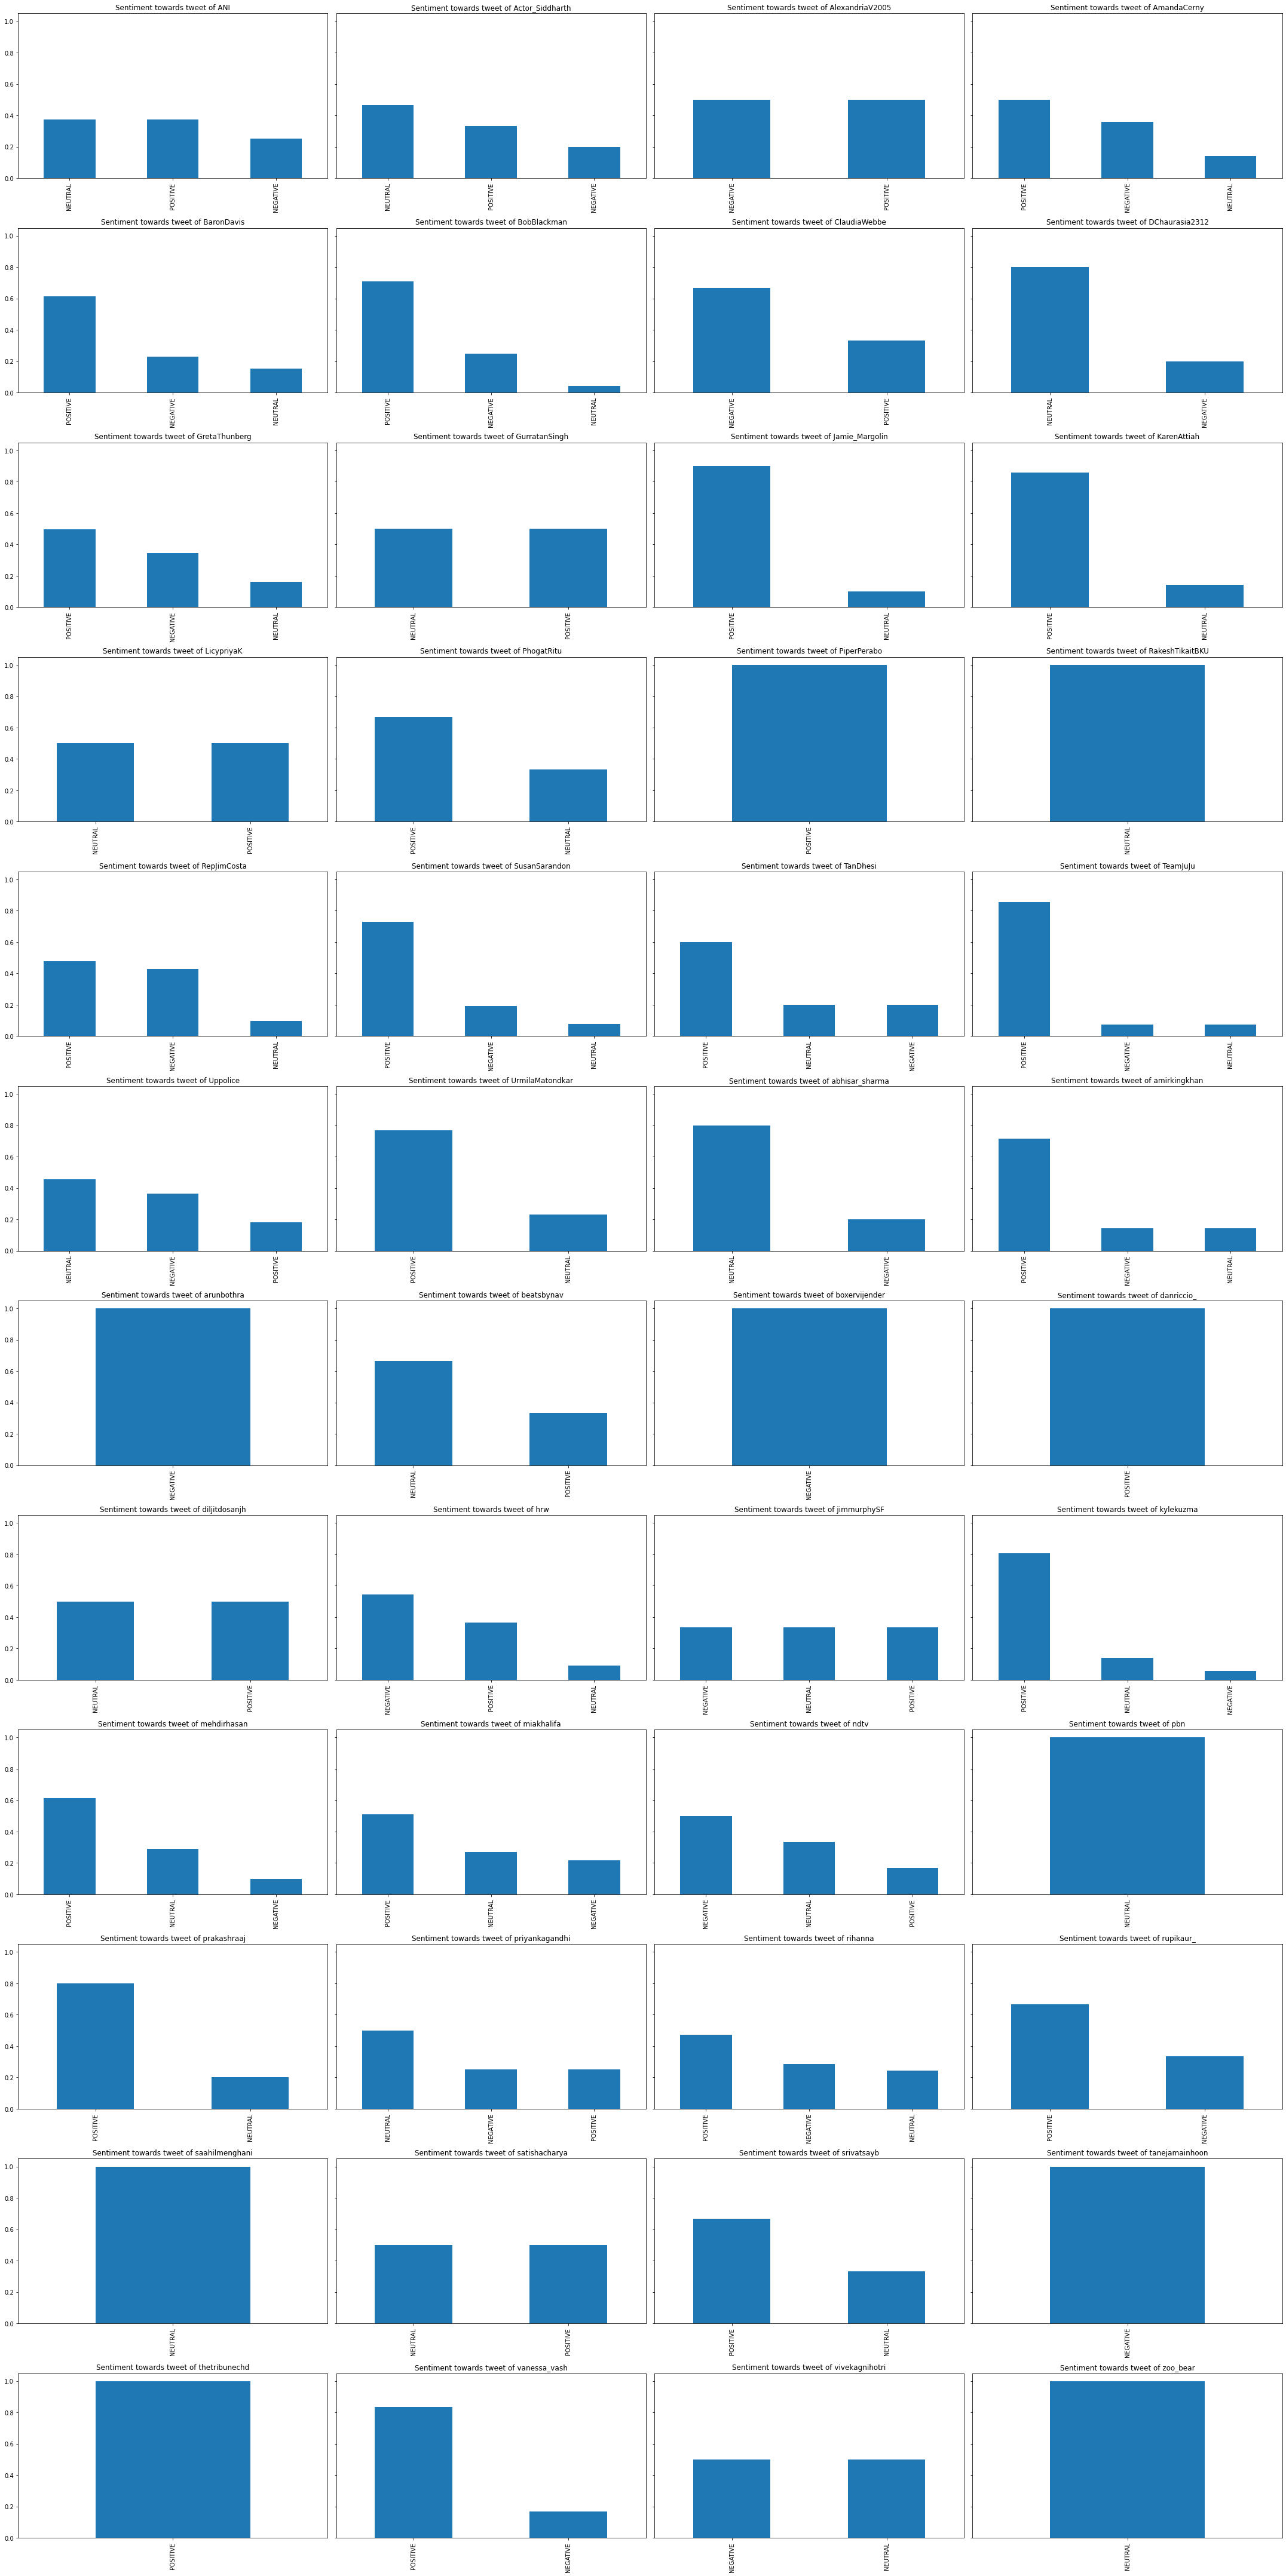

In [28]:
fig, axes = plt.subplots(top_celeb_tweets.shape[0]//4, 4, figsize=(30,60), sharey=True)
axises = axes.flatten()
fig.set_tight_layout(True)
i=0
for index, row in top_celeb_tweets.iterrows():
    processed_tweets_df_reply = processed_tweets_df_replies[processed_tweets_df_replies["related_id"]==row['id']]
    df = pd.DataFrame()
    sid = SentimentIntensityAnalyzer()
    df["text_processed"]=processed_tweets_df_reply["text_processed"].to_numpy()
    if df.shape[0]<1:
        continue
    df['scores'] = df['text_processed'].apply(lambda text_processed: sid.polarity_scores(text_processed))
    df['compound'] = df['scores'].apply(lambda score_dict: score_dict['compound'])
    df['sentiment_type']=''
    df.loc[df.compound>0,'sentiment_type']='POSITIVE'
    df.loc[df.compound==0 ,'sentiment_type']='NEUTRAL'
    df.loc[df.compound<0,'sentiment_type']='NEGATIVE'
    df.sentiment_type.value_counts(normalize=True).plot.bar(ax=axises[i],title="Sentiment towards tweet of "+row['username'])
    i+=1
for ax in axises[i:]:
    ax.set_visible(False)

### Named Entity Recognition

#### Couldn't identify the political stand of celbrities using NER even after custom training the NER model for detecting political parties and making use of Wikidata. Skipping this part from the scope of coursework

In [ ]:
import spacy
import en_core_web_trf

In [ ]:
Topics =  list(sent_topics_outdf_grpd)
fig, axes = plt.subplots(6, 4, figsize=(30,30), sharey=True)
unique_tweets = pd.DataFrame()
fig.set_tight_layout(True)
for i, ax in enumerate(axes.flatten()):
    if i<num_topics:
        topic = Topics[i][1]  
    df = pd.DataFrame()
    df["text_processed"]=topic[0].to_numpy()
    #save for NER
    unique_tweets.append(df)

unique_tweets_list = list(unique_tweets['text_processed'].values)

#Use a spacy model trained using our own dataset
nlp = spacy.load(r".\spacy_trained_model")


entities = list()

for tweet_text in unique_tweets_list:
  doc = nlp(tweet_text)
  for ne in doc.ents:
    print('\tNE found: ', ne.start_char, ne.end_char, ne.label_, ne.text,"--",tweet_text)
    entities.append(ne.text)

#print(entities)